<a href="https://colab.research.google.com/github/BobettiFP/HAIR-lab/blob/Computational-Linguistics/Process_Network_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 49 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,670 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

In [ ]:
!pip install pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.3 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=83d517db5dc24e7404d40d455104e1ef1e008956ef4a6cdd5e00bf1d6796332c
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
#import packages
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import pm4py
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer


/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

class AuthenticationProcess:
    def __init__(self, processes):
        self.processes = processes

    def get_initial_choices(self):
        return [steps[0][0] for steps in self.processes.values()]

    def analyze_processes(self):
        analysis = {}
        for process_name, steps in self.processes.items():
            type_counts = {"HUMAN": 0, "MECHANICAL": 0, "DIGITAL": 0, "BIOMETRIC": 0, "NETWORK": 0, "AI": 0, "End": 0}
            total_weight = 0
            for step, actor_type, weight in steps:
                type_counts[actor_type] += 1
                total_weight += weight

            analysis[process_name] = {
                "type_distribution": type_counts,
                "total_time": total_weight,
                "step_count": len(steps)
            }
        return analysis

class GraphVisualizer:
    NODE_COLORS = {
        "Customer": "lightgreen",
        "End": "red",
        "HUMAN": "palegreen",
        "MECHANICAL": "sandybrown",
        "DIGITAL": "skyblue",
        "BIOMETRIC": "plum",
        "NETWORK": "lightcoral",
        "AI": "gold",
        "AUTHENTICATION": "steelblue"
    }

    @staticmethod
    def get_node_color(node_name, resource_type):
        if node_name in ["Customer", "Banker"]:
            return GraphVisualizer.NODE_COLORS[node_name]
        elif "Authentication" in node_name:
            return GraphVisualizer.NODE_COLORS["AUTHENTICATION"]
        elif resource_type in GraphVisualizer.NODE_COLORS:
            return GraphVisualizer.NODE_COLORS[resource_type]
        return GraphVisualizer.NODE_COLORS["DIGITAL"]

    def create_network_graph(self, processes, initial_choices):
        G = nx.DiGraph()
        for choice in initial_choices:
            G.add_edge("Customer", choice, weight=1)

        for process_steps in processes.values():
            for i in range(len(process_steps) - 1):
                current_step, current_type, weight = process_steps[i]
                next_step, next_type, _ = process_steps[i + 1]
                G.add_edge(current_step, next_step, weight=weight)
                G.nodes[current_step]['type'] = current_type
                G.nodes[next_step]['type'] = next_type

            # Connect "Authentication Complete" to "End"
            if process_steps[-1][0] == "Authentication Complete":
                G.add_edge(process_steps[-1][0], "End", weight=0)
                G.nodes["End"]['type'] = "End"

        pos = graphviz_layout(G, prog='dot', args='-Grankdir=LR')
        node_colors = [self.get_node_color(node, G.nodes[node].get('type', 'DIGITAL')) for node in G.nodes()]
        return G, pos, node_colors


    def visualize_graph(self, G, pos, node_colors, year):
        plt.figure(figsize=(100, 10))
        nx.draw(G, pos,
                with_labels=True,
                node_size=3000,
                node_color=node_colors,
                font_size=8,
                font_weight='bold',
                edge_color='gray',
                arrowsize=20,
                node_shape='o')

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                      label=actor_type,
                                      markerfacecolor=color, markersize=10)
                           for actor_type, color in self.NODE_COLORS.items()]
        plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"Bank Authentication Processes with Actor Types {year}", fontsize=14)
        return plt

class ProcessAnalyzer:
    @staticmethod
    def print_analysis_results(analysis):
        print("\nAUTHENTICATION PROCESS ANALYSIS")
        print("=" * 50)
        for process_name, data in analysis.items():
            print(f"\n{process_name.upper()} PROCESS")
            print("-" * 30)
            print("\nActor Type Distribution:")
            for actor_type, count in data["type_distribution"].items():
                if count > 0:
                    print(f"{actor_type:12} : {count:3d} steps ({count / data['step_count'] * 100:.1f}%)")
            print(f"\nTiming Analysis:")
            print(f"Total Steps     : {data['step_count']}")
            print(f"Total Time      : {data['total_time']} seconds ({data['total_time'] / 60:.1f} minutes)")
            print(f"Average Time    : {data['total_time'] / data['step_count']:.1f} seconds per step")

class VisualizationPlotter:
    def create_time_distribution_plot(self, processes, year):
        actor_times = {"HUMAN": [], "MECHANICAL": [], "DIGITAL": [], "BIOMETRIC": [], "NETWORK": [], "AI": [], "End": []}
        actor_steps = {"HUMAN": [], "MECHANICAL": [], "DIGITAL": [], "BIOMETRIC": [], "NETWORK": [], "AI": [], "End": []}
        processes_list, total_times = [], []

        for process_name, steps in processes.items():
            processes_list.append(process_name)
            process_times = {actor: 0 for actor in actor_times.keys()}
            process_steps = {actor: 0 for actor in actor_steps.keys()}
            for _, actor_type, weight in steps:
                process_times[actor_type] += weight
                process_steps[actor_type] += 1
            for actor in actor_times.keys():
                actor_times[actor].append(process_times[actor])
                actor_steps[actor].append(process_steps[actor])
            total_times.append(sum(process_times.values()))

        sorted_indices = np.argsort(total_times)[::-1]
        processes_list = [processes_list[i] for i in sorted_indices]
        total_times = [total_times[i] for i in sorted_indices]
        for actor in actor_times.keys():
            actor_times[actor] = [actor_times[actor][i] for i in sorted_indices]
            actor_steps[actor] = [actor_steps[actor][i] for i in sorted_indices]

        plt.figure(figsize=(12, 10))
        colors = {"HUMAN": "palegreen", "MECHANICAL": "sandybrown", "DIGITAL": "skyblue", "BIOMETRIC": "plum", "NETWORK": "lightcoral", "AI": "gold", "End": "red"}
        bottom = np.zeros(len(processes_list))

        for actor, times in actor_times.items():
            if any(times):
                bar = plt.bar(processes_list, times, bottom=bottom, color=colors[actor], label=actor)
                for i, time in enumerate(times):
                    if time > 0:
                        steps = actor_steps[actor][i]
                        percentage = (time / total_times[i]) * 100
                        plt.text(
                            i, bottom[i] + time / 2,
                            f"{percentage:.1f}% ({steps} steps, {time} sec)",
                            ha='center', va='center', fontsize=8
                        )
                bottom += times

        # Add total times on top of the bars
        for i, total_time in enumerate(total_times):
            plt.text(
                i, bottom[i] + 5,  # Position slightly above the highest bar
                f"Total: {total_time} sec",
                ha='center', va='center', fontsize=10, fontweight='bold', color='black'
            )

        plt.title(f"Authentication Process Times by Actor Type, Low Digital Literacy {year}", pad=20)
        plt.xlabel("Authentication Process")
        plt.ylabel("Time (seconds)")
        plt.legend(title="Actor Types", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.ylim(0,1000)
        return plt



In [ ]:
# Example usage
if __name__ == "__main__":
    # Define authentication processes (partial example provided)
    AUTHENTICATION_PROCESSES = {
    "Mobile Banking": [
        # Initial Access
        ("Turn On Mobile Device", "HUMAN", 5),
        ("Biometric Unlock Device", "BIOMETRIC", 2),
        ("Verify Device Registration", "NETWORK", 1),

        # App Launch
        ("Locate and Open Mobile Banking App", "HUMAN", 5),
        ("Verify App Integrity", "DIGITAL", 1),
        ("Check App Version", "DIGITAL", 1),
        ("Perform Security Updates", "NETWORK", 60),
        ("Establish Secure Connection", "NETWORK", 2),
        ("Verify SSL Certificate", "NETWORK", 1),

        # Device Verification
        ("Collect Device Fingerprint", "DIGITAL", 1),
        ("Check Device Security", "DIGITAL", 2),
        ("Verify Trusted Device", "NETWORK", 1),
        ("Get Geographic Location", "NETWORK", 3),
        ("Assess Location Risk", "AI", 1),

        # User Authentication
        ("Collect User Credentials", "HUMAN", 15),
        ("Check Account Status", "NETWORK", 1),
        ("Validate Credentials", "DIGITAL", 2),
        ("Perform Risk Assessment", "AI", 1),

        # Biometric Verification
        ("Request Biometric", "DIGITAL", 1),
        ("Capture Biometric", "BIOMETRIC", 3),
        ("Validate Biometric", "AI", 2),
        ("Process Fallback", "DIGITAL", 15),

        # 2FA
        ("Generate Token", "DIGITAL", 1),
        ("Send Authentication Code", "NETWORK", 3),
        ("Input Verification Code", "HUMAN", 20),
        ("Validate Code", "DIGITAL", 1),
        ("Verify Match", "DIGITAL", 1),

        # Security Checks
        ("Check Patterns", "AI", 1),
        ("Analyze Behavior", "AI", 1),
        ("Calculate Risk", "AI", 1),
        ("Evaluate Security", "AI", 1),

        # Session Setup
        ("Generate Session", "DIGITAL", 1),
        ("Set Parameters", "DIGITAL", 1),
        ("Initialize Monitoring", "AI", 1),
        ("Start Continuous Authentication", "AI", 1),

        # Completion
        ("Record Login", "DIGITAL", 1),
        ("Log Details", "DIGITAL", 1),
        ("Send Notification", "NETWORK", 1),
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "Internet Banking": [
        # Initial Check
        ("Verify Browser Security", "DIGITAL", 2),
        ("Check Browser Version", "DIGITAL", 1),
        ("Validate Browser", "DIGITAL", 2),
        ("Establish Connection", "NETWORK", 3),
        ("Verify SSL/TLS", "NETWORK", 2),

        # Environment Check
        ("Collect IP Info", "NETWORK", 2),
        ("Verify Location", "NETWORK", 2),
        ("Assess Risk", "AI", 2),
        ("Check VPN/Proxy", "NETWORK", 2),

        # Credentials
        ("Load Password Manager", "DIGITAL", 2),
        ("Input Username", "HUMAN", 15),
        ("Input Password", "HUMAN", 15),
        ("Process Manager Data", "DIGITAL", 3),

        # Validation
        ("Format Check", "DIGITAL", 1),
        ("Account Status", "NETWORK", 2),
        ("Verify Credentials", "NETWORK", 5),
        ("Login Risk", "AI", 2),

        # CAPTCHA
        ("Generate CAPTCHA", "AI", 1),
        ("Solve CAPTCHA", "HUMAN", 15),
        ("Validate Response", "AI", 2),

        # 2FA
        ("Auth Level Check", "AI", 1),
        ("Generate Token", "DIGITAL", 1),
        ("Send Code", "NETWORK", 3),
        ("User Input", "HUMAN", 20),
        ("Validate Code", "DIGITAL", 1),

        # Biometric
        ("Check Availability", "DIGITAL", 1),
        ("Request Biometric", "DIGITAL", 1),
        ("Process Biometric", "BIOMETRIC", 3),
        ("Handle Fallback", "DIGITAL", 10),

        # Session
        ("Create Session", "DIGITAL", 1),
        ("Set Parameters", "DIGITAL", 1),
        ("Start Monitoring", "AI", 1),
        ("Begin Analysis", "AI", 1),

        # Completion
        ("Record Success", "DIGITAL", 1),
        ("Log Details", "DIGITAL", 1),
        ("Send Notice", "NETWORK", 1),
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "Email Transactions": [
        # Security
        ("Verify Security", "DIGITAL", 3),
        ("Check Client", "DIGITAL", 3),
        ("Validate Connection", "NETWORK", 2),

        # Credentials
        ("Access Manager", "DIGITAL", 2),
        ("Input Credentials", "HUMAN", 25),
        ("Validate Format", "DIGITAL", 1),
        ("Process Login", "NETWORK", 3),

        # Verification
        ("Check Status", "NETWORK", 1),
        ("Verify Rights", "DIGITAL", 1),
        ("Generate Token", "DIGITAL", 1),
        ("Process Code", "HUMAN", 20),

        # Assessment
        ("Analyze Pattern", "AI", 2),
        ("Location Risk", "AI", 2),
        ("Security Level", "AI", 1),

        # Session
        ("Create Session", "DIGITAL", 2),
        ("Start Monitoring", "AI", 2),
        ("Set Controls", "DIGITAL", 1),

        # Completion
        ("Record Access", "DIGITAL", 1),
        ("Send Alert", "NETWORK", 1),
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "Branch Visits": [
        # Processing
        ("Document Check", "HUMAN", 60),
        ("Completeness Check", "HUMAN", 45),
        ("Record Purpose", "HUMAN", 15),

        # Identity
        ("Collect ID", "HUMAN", 15),
        ("Verify Authenticity", "HUMAN", 45),
        ("Cross-reference", "NETWORK", 15),
        ("Photo Validation", "BIOMETRIC", 15),

        # Biometric
        ("Prepare System", "MECHANICAL", 5),
        ("Capture Print", "BIOMETRIC", 10),
        ("Verify Match", "AI", 5),
        ("Alternative Bio", "BIOMETRIC", 10),

        # OTP
        ("Generate OTP", "DIGITAL", 1),
        ("Send OTP", "NETWORK", 3),
        ("Input OTP", "HUMAN", 30),

        # Records
        ("Update Records", "NETWORK", 5),
        ("Record Status", "DIGITAL", 5),
        ("Log Details", "DIGITAL", 5),

        # Completion
        ("Final Check", "DIGITAL", 5),
        ("Record Time", "DIGITAL", 3),
        ("Authentication Complete", "DIGITAL", 2)
    ]
}


    year = 2024

    auth_process = AuthenticationProcess(AUTHENTICATION_PROCESSES)
    initial_choices = auth_process.get_initial_choices()

    graph_visualizer = GraphVisualizer()
    G, pos, node_colors = graph_visualizer.create_network_graph(AUTHENTICATION_PROCESSES, initial_choices)
    graph_visualizer.visualize_graph(G, pos, node_colors, year).show()

    analysis = auth_process.analyze_processes()
    ProcessAnalyzer.print_analysis_results(analysis)

    plotter = VisualizationPlotter()
    plotter.create_time_distribution_plot(AUTHENTICATION_PROCESSES, year).show()


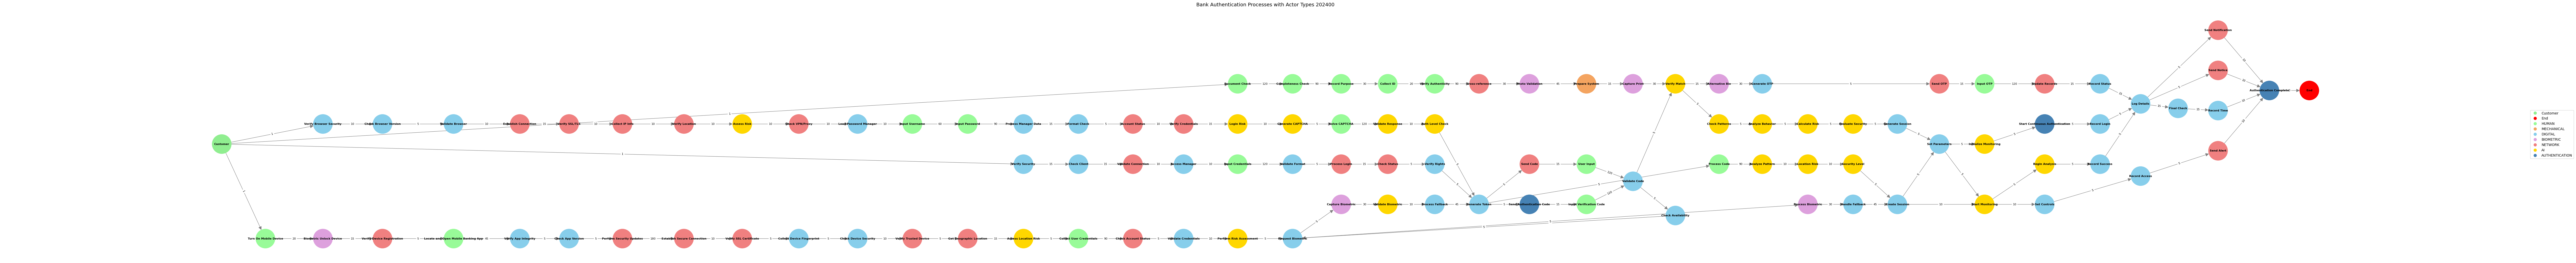


AUTHENTICATION PROCESS ANALYSIS

MOBILE BANKING PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :   4 steps (10.3%)
DIGITAL      :  15 steps (38.5%)
BIOMETRIC    :   2 steps (5.1%)
NETWORK      :   9 steps (23.1%)
AI           :   9 steps (23.1%)

Timing Analysis:
Total Steps     : 39
Total Time      : 745 seconds (12.4 minutes)
Average Time    : 19.1 seconds per step

INTERNET BANKING PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :   4 steps (10.8%)
DIGITAL      :  16 steps (43.2%)
BIOMETRIC    :   1 steps (2.7%)
NETWORK      :   9 steps (24.3%)
AI           :   7 steps (18.9%)

Timing Analysis:
Total Steps     : 37
Total Time      : 720 seconds (12.0 minutes)
Average Time    : 19.5 seconds per step

EMAIL TRANSACTIONS PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :   2 steps (10.0%)
DIGITAL      :  10 steps (50.0%)
NETWORK      :   4 steps (20.0%)
AI           :   4 steps (20.0%)

Timing An

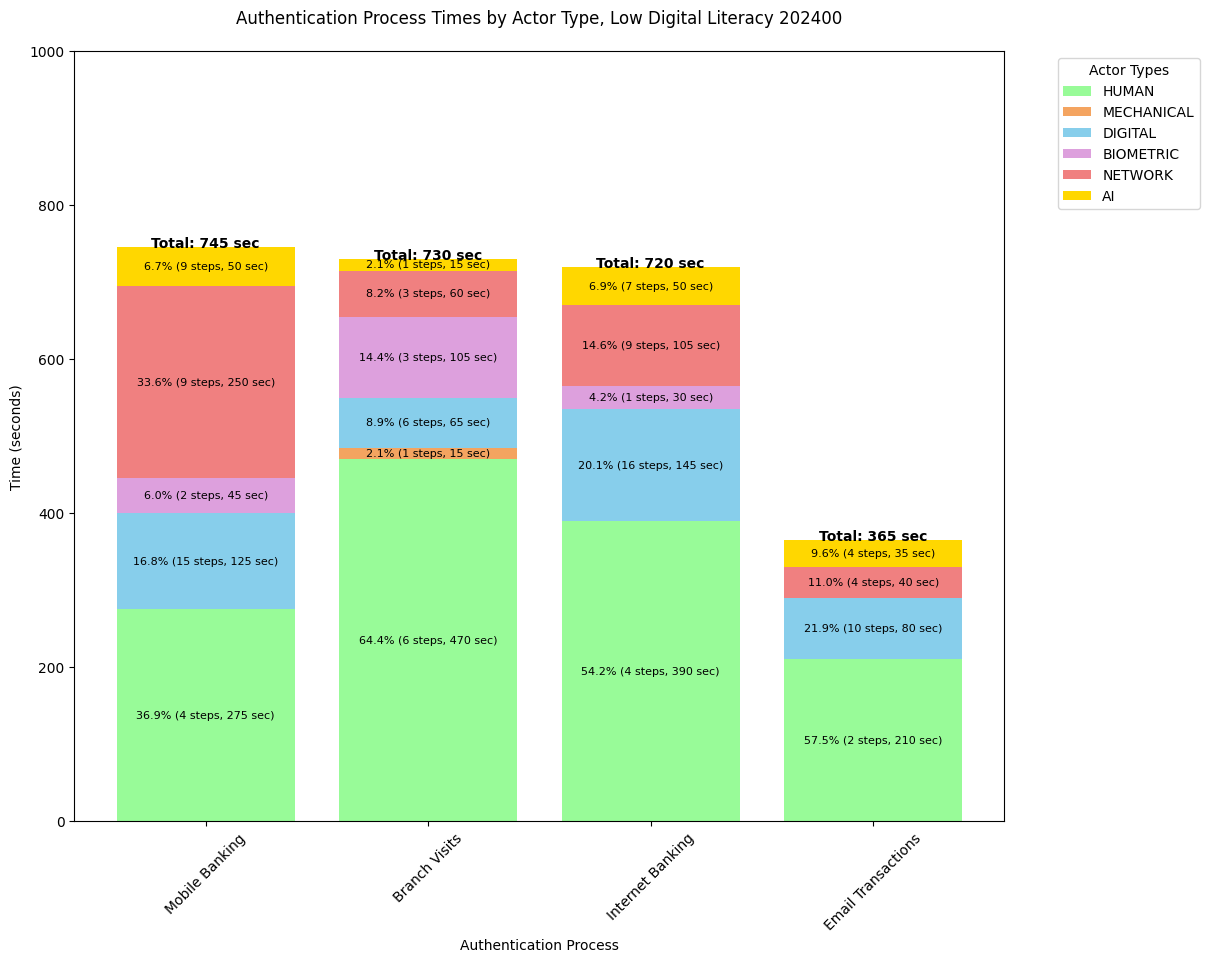

In [ ]:
if __name__ == "__main__":
    # Define authentication processes (partial example provided)
    AUTHENTICATION_PROCESSES = {
    "Mobile Banking": [
        # Initial Access (Much slower due to unfamiliarity)
        ("Turn On Mobile Device", "HUMAN", 20),          # Confusion with buttons/gestures
        ("Biometric Unlock Device", "BIOMETRIC", 15),    # New concept, multiple attempts
        ("Verify Device Registration", "NETWORK", 5),

        # App Launch (Significant difficulty locating and understanding apps)
        ("Locate and Open Mobile Banking App", "HUMAN", 45),  # Confusion with icons/menus
        ("Verify App Integrity", "DIGITAL", 5),
        ("Check App Version", "DIGITAL", 5),
        ("Perform Security Updates", "NETWORK", 180),    # Updates are confusing
        ("Establish Secure Connection", "NETWORK", 10),
        ("Verify SSL Certificate", "NETWORK", 5),

        # Device Verification
        ("Collect Device Fingerprint", "DIGITAL", 5),
        ("Check Device Security", "DIGITAL", 10),
        ("Verify Trusted Device", "NETWORK", 5),
        ("Get Geographic Location", "NETWORK", 15),      # GPS concept is new
        ("Assess Location Risk", "AI", 5),

        # User Authentication (Much slower typing and understanding)
        ("Collect User Credentials", "HUMAN", 90),       # Slow typing, password complexity
        ("Check Account Status", "NETWORK", 5),
        ("Validate Credentials", "DIGITAL", 10),
        ("Perform Risk Assessment", "AI", 5),

        # Biometric Verification (Very new concept)
        ("Request Biometric", "DIGITAL", 5),
        ("Capture Biometric", "BIOMETRIC", 30),         # Multiple attempts likely
        ("Validate Biometric", "AI", 10),
        ("Process Fallback", "DIGITAL", 45),            # Backup methods take longer

        # 2FA (Complex new security concept)
        ("Generate Token", "DIGITAL", 5),
        ("Send Authentication Code", "NETWORK", 15),
        ("Input Verification Code", "HUMAN", 120),       # Finding and entering code
        ("Validate Code", "DIGITAL", 5),
        ("Verify Match", "DIGITAL", 5),

        # Security Checks
        ("Check Patterns", "AI", 5),
        ("Analyze Behavior", "AI", 5),
        ("Calculate Risk", "AI", 5),
        ("Evaluate Security", "AI", 5),

        # Session Setup
        ("Generate Session", "DIGITAL", 5),
        ("Set Parameters", "DIGITAL", 5),
        ("Initialize Monitoring", "AI", 5),
        ("Start Continuous Authentication", "AI", 5),

        # Completion
        ("Record Login", "DIGITAL", 5),
        ("Log Details", "DIGITAL", 5),
        ("Send Notification", "NETWORK", 10),
        ("Authentication Complete", "DIGITAL", 5)
    ],

    "Internet Banking": [
        # Initial Check (New to computers)
        ("Verify Browser Security", "DIGITAL", 10),
        ("Check Browser Version", "DIGITAL", 5),
        ("Validate Browser", "DIGITAL", 10),
        ("Establish Connection", "NETWORK", 15),
        ("Verify SSL/TLS", "NETWORK", 10),

        # Environment Check
        ("Collect IP Info", "NETWORK", 10),
        ("Verify Location", "NETWORK", 10),
        ("Assess Risk", "AI", 10),
        ("Check VPN/Proxy", "NETWORK", 10),

        # Credentials (Slow typing, unfamiliar with keyboards)
        ("Load Password Manager", "DIGITAL", 10),
        ("Input Username", "HUMAN", 60),                # Slow typing
        ("Input Password", "HUMAN", 90),                # Complex passwords are challenging
        ("Process Manager Data", "DIGITAL", 15),

        # Validation
        ("Format Check", "DIGITAL", 5),
        ("Account Status", "NETWORK", 10),
        ("Verify Credentials", "NETWORK", 15),
        ("Login Risk", "AI", 10),

        # CAPTCHA (Very confusing concept)
        ("Generate CAPTCHA", "AI", 5),
        ("Solve CAPTCHA", "HUMAN", 120),               # Much harder to understand
        ("Validate Response", "AI", 10),

        # 2FA (Complex security concept)
        ("Auth Level Check", "AI", 5),
        ("Generate Token", "DIGITAL", 5),
        ("Send Code", "NETWORK", 15),
        ("User Input", "HUMAN", 120),                  # Finding and entering code
        ("Validate Code", "DIGITAL", 5),

        # Biometric
        ("Check Availability", "DIGITAL", 5),
        ("Request Biometric", "DIGITAL", 5),
        ("Process Biometric", "BIOMETRIC", 30),
        ("Handle Fallback", "DIGITAL", 45),

        # Session
        ("Create Session", "DIGITAL", 5),
        ("Set Parameters", "DIGITAL", 5),
        ("Start Monitoring", "AI", 5),
        ("Begin Analysis", "AI", 5),

        # Completion
        ("Record Success", "DIGITAL", 5),
        ("Log Details", "DIGITAL", 5),
        ("Send Notice", "NETWORK", 10),
        ("Authentication Complete", "DIGITAL", 5)
    ],

    "Email Transactions": [
        # Security (All new concepts)
        ("Verify Security", "DIGITAL", 15),
        ("Check Client", "DIGITAL", 15),
        ("Validate Connection", "NETWORK", 10),

        # Credentials (Slow typing)
        ("Access Manager", "DIGITAL", 10),
        ("Input Credentials", "HUMAN", 120),           # Very slow typing
        ("Validate Format", "DIGITAL", 5),
        ("Process Login", "NETWORK", 15),

        # Verification
        ("Check Status", "NETWORK", 5),
        ("Verify Rights", "DIGITAL", 5),
        ("Generate Token", "DIGITAL", 5),
        ("Process Code", "HUMAN", 90),

        # Assessment
        ("Analyze Pattern", "AI", 10),
        ("Location Risk", "AI", 10),
        ("Security Level", "AI", 5),

        # Session
        ("Create Session", "DIGITAL", 10),
        ("Start Monitoring", "AI", 10),
        ("Set Controls", "DIGITAL", 5),

        # Completion
        ("Record Access", "DIGITAL", 5),
        ("Send Alert", "NETWORK", 10),
        ("Authentication Complete", "DIGITAL", 5)
    ],

    "Branch Visits": [
        # Processing (More familiar process)
        ("Document Check", "HUMAN", 120),              # More thorough in the 60s
        ("Completeness Check", "HUMAN", 90),
        ("Record Purpose", "HUMAN", 30),

        # Identity (Traditional process)
        ("Collect ID", "HUMAN", 20),
        ("Verify Authenticity", "HUMAN", 90),
        ("Cross-reference", "NETWORK", 30),
        ("Photo Validation", "BIOMETRIC", 45),

        # Biometric (Very new concept)
        ("Prepare System", "MECHANICAL", 15),
        ("Capture Print", "BIOMETRIC", 30),
        ("Verify Match", "AI", 15),
        ("Alternative Bio", "BIOMETRIC", 30),

        # OTP
        ("Generate OTP", "DIGITAL", 5),
        ("Send OTP", "NETWORK", 15),
        ("Input OTP", "HUMAN", 120),                  # Much harder to understand

        # Records
        ("Update Records", "NETWORK", 15),
        ("Record Status", "DIGITAL", 15),
        ("Log Details", "DIGITAL", 15),

        # Completion
        ("Final Check", "DIGITAL", 15),
        ("Record Time", "DIGITAL", 10),
        ("Authentication Complete", "DIGITAL", 5)
    ]
}


    year = 202400

    auth_process = AuthenticationProcess(AUTHENTICATION_PROCESSES)
    initial_choices = auth_process.get_initial_choices()

    graph_visualizer = GraphVisualizer()
    G, pos, node_colors = graph_visualizer.create_network_graph(AUTHENTICATION_PROCESSES, initial_choices)
    graph_visualizer.visualize_graph(G, pos, node_colors, year).show()

    analysis = auth_process.analyze_processes()
    ProcessAnalyzer.print_analysis_results(analysis)

    plotter = VisualizationPlotter()
    plotter.create_time_distribution_plot(AUTHENTICATION_PROCESSES, year).show()

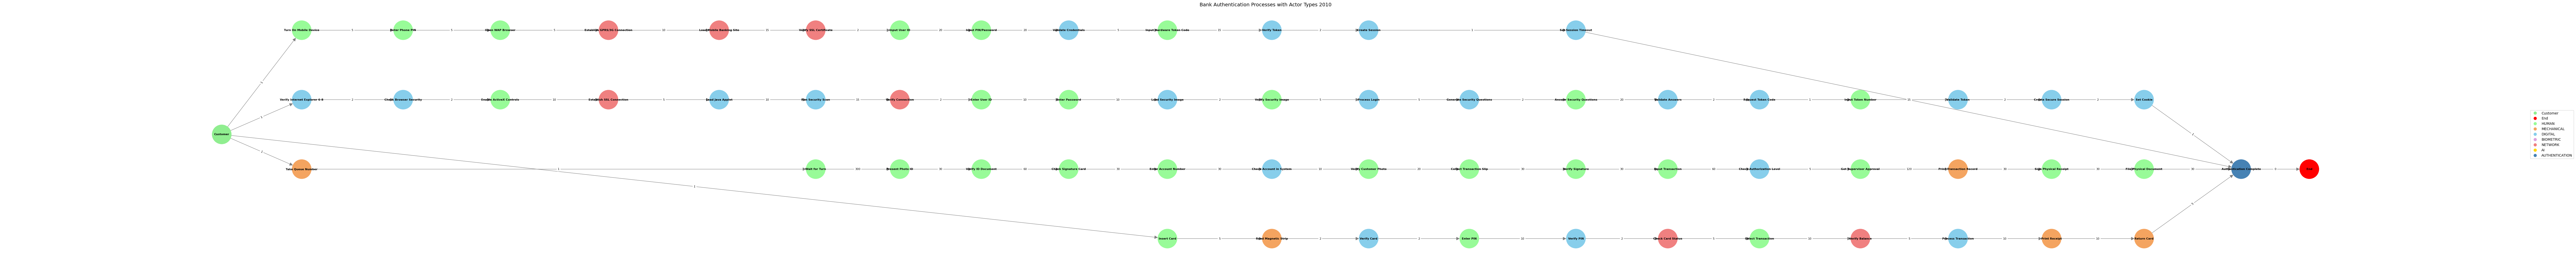


AUTHENTICATION PROCESS ANALYSIS

MOBILE BANKING PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :   6 steps (42.9%)
DIGITAL      :   5 steps (35.7%)
NETWORK      :   3 steps (21.4%)

Timing Analysis:
Total Steps     : 14
Total Time      : 107 seconds (1.8 minutes)
Average Time    : 7.6 seconds per step

INTERNET BANKING PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :   6 steps (28.6%)
DIGITAL      :  13 steps (61.9%)
NETWORK      :   2 steps (9.5%)

Timing Analysis:
Total Steps     : 21
Total Time      : 124 seconds (2.1 minutes)
Average Time    : 5.9 seconds per step

BRANCH BANKING PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :  12 steps (70.6%)
MECHANICAL   :   2 steps (11.8%)
DIGITAL      :   3 steps (17.6%)

Timing Analysis:
Total Steps     : 17
Total Time      : 817 seconds (13.6 minutes)
Average Time    : 48.1 seconds per step

ATM TRANSACTION PROCESS
------------------------------

A

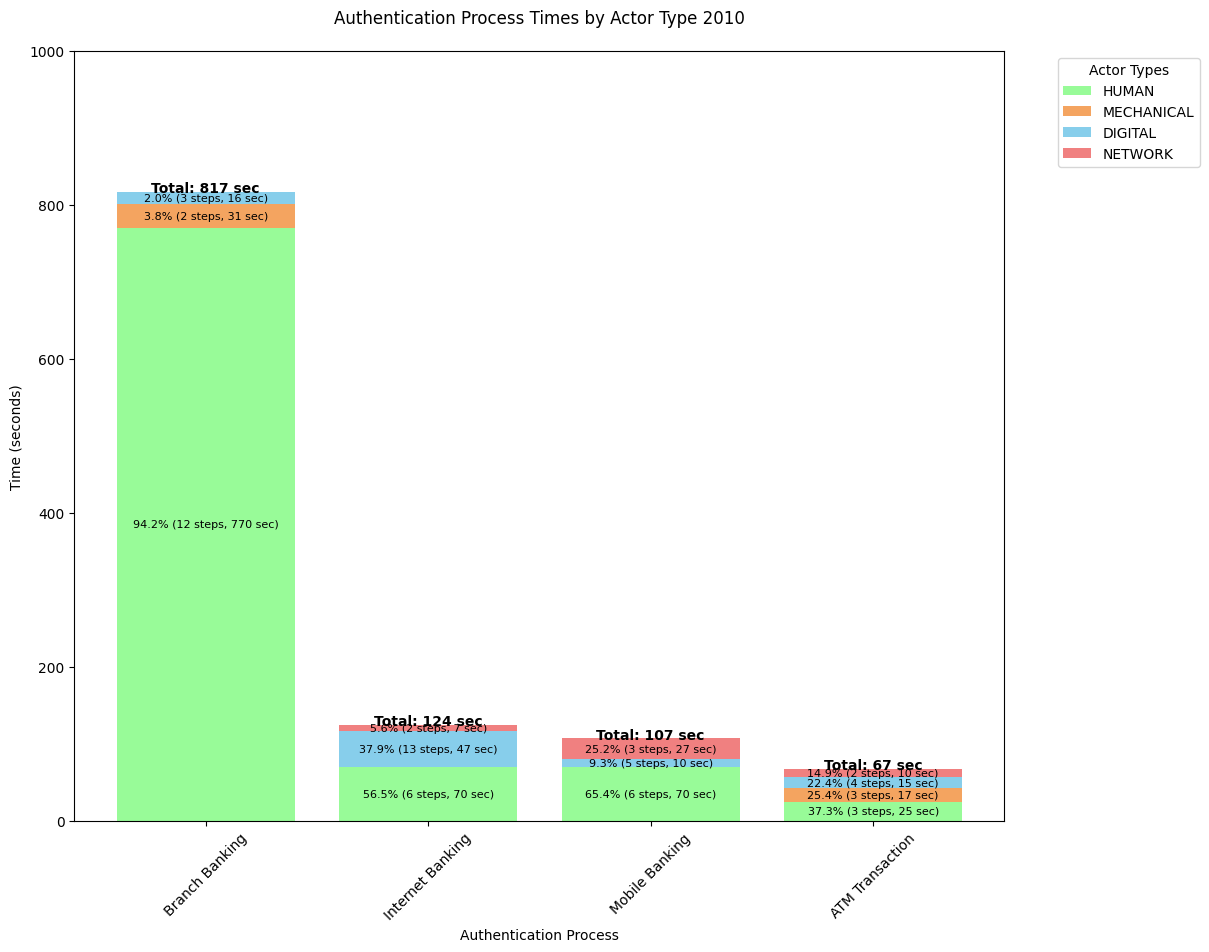

In [ ]:
if __name__ == "__main__":
    # Define authentication processes (partial example provided)
    # 2010 Authentication Process
# Note: Mobile banking was in early stages
# Biometric authentication was rare
# Hardware tokens were common for 2FA
# SMS verification was becoming popular



    AUTHENTICATION_PROCESSES = {
    "Mobile Banking": [  # Basic mobile banking in 2010
        # Initial Access
        ("Turn On Mobile Device", "HUMAN", 5),
        ("Enter Phone PIN", "HUMAN", 5),
        ("Open WAP Browser", "HUMAN", 5),  # Many banks used WAP

        # Connection
        ("Establish GPRS/3G Connection", "NETWORK", 10),  # Slower networks
        ("Load Mobile Banking Site", "NETWORK", 15),      # WAP sites were slower
        ("Verify SSL Certificate", "NETWORK", 2),

        # Authentication
        ("Input User ID", "HUMAN", 20),                   # More typing on basic phones
        ("Input PIN/Password", "HUMAN", 20),
        ("Validate Credentials", "DIGITAL", 5),

        # Token Authentication (if required)
        ("Input Hardware Token Code", "HUMAN", 15),       # Physical tokens were common
        ("Verify Token", "DIGITAL", 2),

        # Session
        ("Create Session", "DIGITAL", 1),
        ("Set Session Timeout", "DIGITAL", 1),            # Short timeouts were common
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "Internet Banking": [
        # Browser Check
        ("Verify Internet Explorer 6-8", "DIGITAL", 2),   # IE was dominant
        ("Check Browser Security", "DIGITAL", 2),
        ("Enable ActiveX Controls", "HUMAN", 10),         # Common requirement
        ("Establish SSL Connection", "NETWORK", 5),

        # Security Setup
        ("Load Java Applet", "DIGITAL", 10),             # Security applets were common
        ("Run Security Scan", "DIGITAL", 15),            # Virus/malware check
        ("Verify Connection", "NETWORK", 2),

        # Login
        ("Enter User ID", "HUMAN", 10),
        ("Enter Password", "HUMAN", 10),
        ("Load Security Image", "DIGITAL", 2),           # Site authentication images
        ("Verify Security Image", "HUMAN", 5),
        ("Process Login", "DIGITAL", 5),

        # Additional Authentication
        ("Generate Security Questions", "DIGITAL", 2),
        ("Answer Security Questions", "HUMAN", 20),      # Common second factor
        ("Validate Answers", "DIGITAL", 2),

        # Hardware Token (for transactions)
        ("Request Token Code", "DIGITAL", 1),
        ("Input Token Number", "HUMAN", 15),
        ("Validate Token", "DIGITAL", 2),

        # Session
        ("Create Secure Session", "DIGITAL", 2),
        ("Set Cookie", "DIGITAL", 1),
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "Branch Banking": [
        # Initial Processing
        ("Take Queue Number", "MECHANICAL", 1),
        ("Wait for Turn", "HUMAN", 300),                # Longer wait times were common

        # Identity Verification
        ("Present Photo ID", "HUMAN", 30),
        ("Verify ID Document", "HUMAN", 60),
        ("Check Signature Card", "HUMAN", 30),          # Physical signature verification

        # Account Verification
        ("Enter Account Number", "HUMAN", 30),
        ("Check Account in System", "DIGITAL", 10),
        ("Verify Customer Photo", "HUMAN", 20),         # Physical photos in system

        # Transaction Authorization
        ("Collect Transaction Slip", "HUMAN", 30),
        ("Verify Signature", "HUMAN", 30),
        ("Input Transaction", "HUMAN", 60),

        # Special Transactions
        ("Check Authorization Level", "DIGITAL", 5),
        ("Get Supervisor Approval", "HUMAN", 120),      # If needed

        # Completion
        ("Print Transaction Record", "MECHANICAL", 30),
        ("Sign Physical Receipt", "HUMAN", 30),
        ("File Physical Document", "HUMAN", 30),
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "ATM Transaction": [                                # Common in 2010
        # Card Processing
        ("Insert Card", "HUMAN", 5),
        ("Read Magnetic Strip", "MECHANICAL", 2),
        ("Verify Card", "DIGITAL", 2),

        # Authentication
        ("Enter PIN", "HUMAN", 10),
        ("Verify PIN", "DIGITAL", 2),
        ("Check Card Status", "NETWORK", 5),

        # Transaction
        ("Select Transaction", "HUMAN", 10),
        ("Verify Balance", "NETWORK", 5),
        ("Process Transaction", "DIGITAL", 10),

        # Completion
        ("Print Receipt", "MECHANICAL", 10),
        ("Return Card", "MECHANICAL", 5),
        ("Authentication Complete", "DIGITAL", 1)
    ]
}


    year = 2010

    auth_process = AuthenticationProcess(AUTHENTICATION_PROCESSES)
    initial_choices = auth_process.get_initial_choices()

    graph_visualizer = GraphVisualizer()
    G, pos, node_colors = graph_visualizer.create_network_graph(AUTHENTICATION_PROCESSES, initial_choices)
    graph_visualizer.visualize_graph(G, pos, node_colors, year).show()

    analysis = auth_process.analyze_processes()
    ProcessAnalyzer.print_analysis_results(analysis)

    plotter = VisualizationPlotter()
    plotter.create_time_distribution_plot(AUTHENTICATION_PROCESSES, year).show()

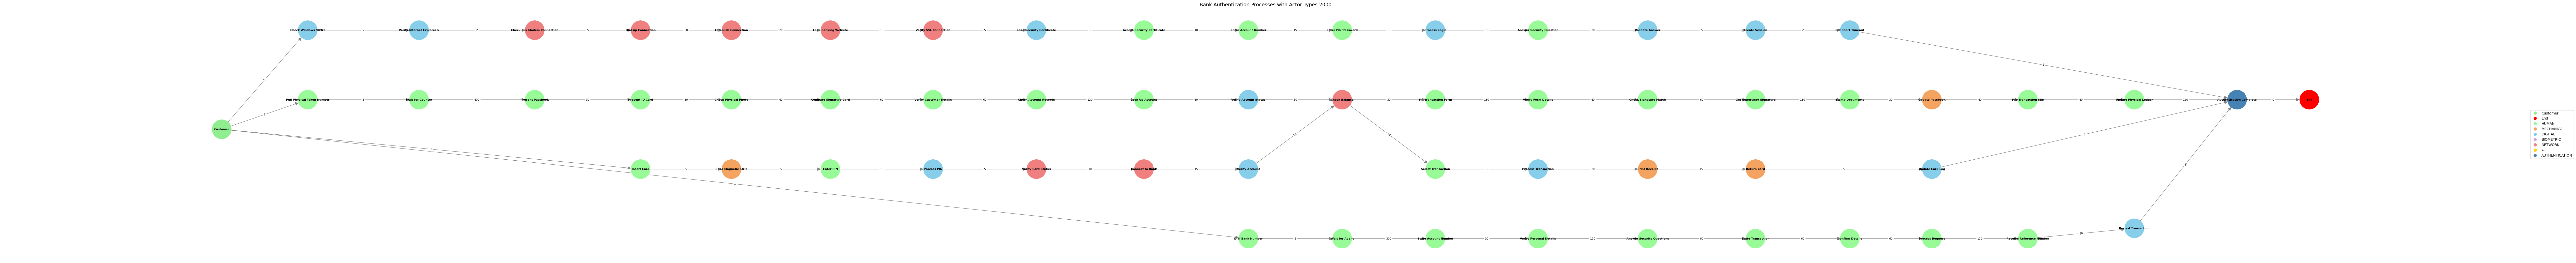


AUTHENTICATION PROCESS ANALYSIS

INTERNET BANKING PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :   4 steps (23.5%)
DIGITAL      :   8 steps (47.1%)
NETWORK      :   5 steps (29.4%)

Timing Analysis:
Total Steps     : 17
Total Time      : 163 seconds (2.7 minutes)
Average Time    : 9.6 seconds per step

BRANCH BANKING PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :  17 steps (85.0%)
MECHANICAL   :   1 steps (5.0%)
DIGITAL      :   2 steps (10.0%)

Timing Analysis:
Total Steps     : 20
Total Time      : 1865 seconds (31.1 minutes)
Average Time    : 93.2 seconds per step

ATM TRANSACTION PROCESS
------------------------------

Actor Type Distribution:
HUMAN        :   3 steps (21.4%)
MECHANICAL   :   3 steps (21.4%)
DIGITAL      :   5 steps (35.7%)
NETWORK      :   3 steps (21.4%)

Timing Analysis:
Total Steps     : 14
Total Time      : 131 seconds (2.2 minutes)
Average Time    : 9.4 seconds per step

TELEPHONE BANKING PROC

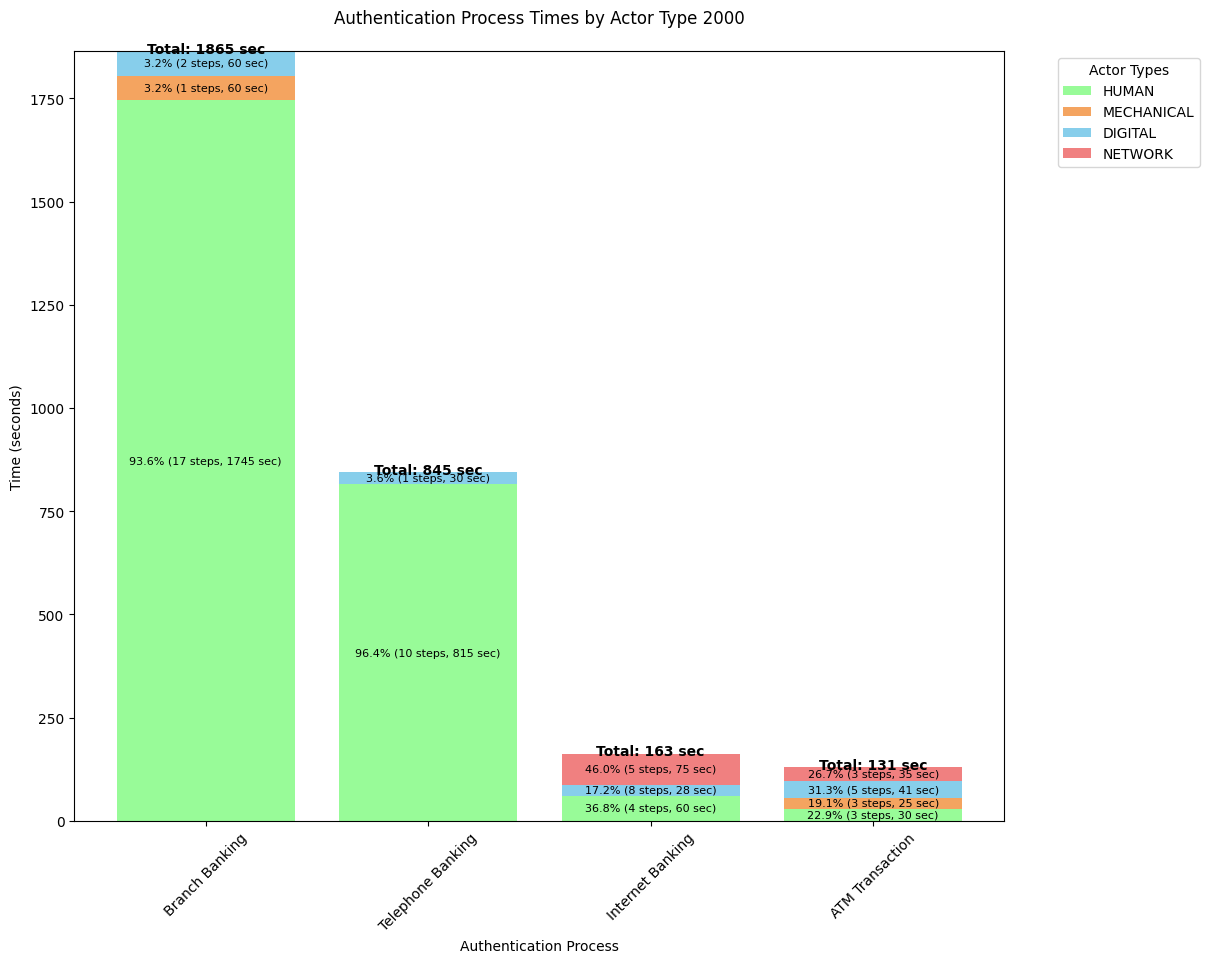

In [ ]:
if __name__ == "__main__":
    # Define authentication processes (partial example provided)
    # 2010 Authentication Process
# Note: Mobile banking was in early stages
# Biometric authentication was rare
# Hardware tokens were common for 2FA
# SMS verification was becoming popular



    AUTHENTICATION_PROCESSES = {
    "Internet Banking": [  # New and basic in 2000
        # System Requirements
        ("Check Windows 98/NT", "DIGITAL", 2),
        ("Verify Internet Explorer 5", "DIGITAL", 2),
        ("Check 56k Modem Connection", "NETWORK", 5),

        # Connection Setup
        ("Dial-up Connection", "NETWORK", 30),          # Dial-up was standard
        ("Establish Connection", "NETWORK", 20),        # Slower connection times
        ("Load Banking Website", "NETWORK", 15),        # Basic HTML sites

        # Basic Security
        ("Verify SSL Connection", "NETWORK", 5),
        ("Load Security Certificate", "DIGITAL", 5),
        ("Accept Security Certificate", "HUMAN", 10),   # Manual certificate acceptance

        # Login Process
        ("Enter Account Number", "HUMAN", 15),
        ("Enter PIN/Password", "HUMAN", 15),
        ("Process Login", "DIGITAL", 10),              # Slower processing

        # Additional Security
        ("Answer Security Question", "HUMAN", 20),
        ("Validate Answer", "DIGITAL", 5),

        # Session
        ("Create Session", "DIGITAL", 2),
        ("Set Short Timeout", "DIGITAL", 1),           # Very short sessions for security
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "Branch Banking": [  # Primary banking method
        # Queue Management
        ("Pull Physical Token Number", "HUMAN", 5),
        ("Wait for Counter", "HUMAN", 600),            # Long wait times common

        # Initial Verification
        ("Present Passbook", "HUMAN", 30),             # Passbooks were standard
        ("Present ID Card", "HUMAN", 30),
        ("Check Physical Photo", "HUMAN", 60),

        # Identity Verification
        ("Compare Signature Card", "HUMAN", 60),       # Primary verification method
        ("Verify Customer Details", "HUMAN", 60),
        ("Check Account Records", "HUMAN", 120),       # Manual record checking

        # Account Verification
        ("Look Up Account", "HUMAN", 60),             # Manual ledger checks
        ("Verify Account Status", "DIGITAL", 30),     # Early computer systems
        ("Check Balance", "DIGITAL", 30),

        # Transaction Processing
        ("Fill Transaction Form", "HUMAN", 180),      # Physical forms required
        ("Verify Form Details", "HUMAN", 60),
        ("Check Signature Match", "HUMAN", 60),

        # Authorization
        ("Get Supervisor Signature", "HUMAN", 180),   # Required for many transactions
        ("Stamp Documents", "HUMAN", 30),
        ("Update Passbook", "MECHANICAL", 60),        # Passbook printing

        # Record Keeping
        ("File Transaction Slip", "HUMAN", 60),
        ("Update Physical Ledger", "HUMAN", 120),     # Backup paper records
        ("Authentication Complete", "HUMAN", 30)
    ],

    "ATM Transaction": [
        # Card Processing
        ("Insert Card", "HUMAN", 5),
        ("Read Magnetic Strip", "MECHANICAL", 5),      # Older, slower readers

        # Verification
        ("Enter PIN", "HUMAN", 10),
        ("Process PIN", "DIGITAL", 5),
        ("Verify Card Status", "NETWORK", 10),         # Slower network verification

        # Account Check
        ("Connect to Bank", "NETWORK", 15),           # Dial-up connection to bank
        ("Verify Account", "DIGITAL", 10),
        ("Check Balance", "NETWORK", 10),

        # Transaction
        ("Select Transaction", "HUMAN", 15),
        ("Process Transaction", "DIGITAL", 20),        # Slower processing
        ("Print Receipt", "MECHANICAL", 15),           # Dot matrix printers

        # Completion
        ("Return Card", "MECHANICAL", 5),
        ("Update Card Log", "DIGITAL", 5),
        ("Authentication Complete", "DIGITAL", 1)
    ],

    "Telephone Banking": [  # Common in 2000
        # Initial Contact
        ("Dial Bank Number", "HUMAN", 5),
        ("Wait for Agent", "HUMAN", 300),             # Long wait times

        # Voice Authentication
        ("State Account Number", "HUMAN", 30),
        ("Verify Personal Details", "HUMAN", 120),    # Extensive verification
        ("Answer Security Questions", "HUMAN", 60),

        # Transaction
        ("State Transaction", "HUMAN", 60),
        ("Confirm Details", "HUMAN", 60),
        ("Process Request", "HUMAN", 120),

        # Completion
        ("Receive Reference Number", "HUMAN", 30),
        ("Record Transaction", "DIGITAL", 30),
        ("Authentication Complete", "HUMAN", 30)
    ]
}
    year = 2000

    auth_process = AuthenticationProcess(AUTHENTICATION_PROCESSES)
    initial_choices = auth_process.get_initial_choices()

    graph_visualizer = GraphVisualizer()
    G, pos, node_colors = graph_visualizer.create_network_graph(AUTHENTICATION_PROCESSES, initial_choices)
    graph_visualizer.visualize_graph(G, pos, node_colors, year).show()

    analysis = auth_process.analyze_processes()
    ProcessAnalyzer.print_analysis_results(analysis)

    plotter = VisualizationPlotter()
    plotter.create_time_distribution_plot(AUTHENTICATION_PROCESSES, year).show()